In [ ]:
pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.8 MB/s eta 0:00:00


In [ ]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
# import matplotlib.pyplot as plt
import cv2
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications import ResNet50
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from tensorflow.keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


import logging

import json
import os
import dill

In [ ]:
!nvidia-smi

Fri Aug 25 15:48:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!gpu_enabled = True

/bin/bash: line 1: gpu_enabled: command not found


In [ ]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)
# ! pip install tensorflow==2.5.0

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.12.0


In [ ]:
import tensorflow as tf

# Check the number of available GPUs (optional)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set the GPU as the default device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Now, TensorFlow will use the GPU for all operations by default


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [ ]:
def dump_json(data, json_file_path):
    with open(json_file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)

def load_json(json_file_path):
    with open(json_file_path, 'r') as json_file:
        loaded_data = json.load(json_file)
    return loaded_data

In [ ]:
def dump_model(model, file_path):
    dir_path = os.path.dirname(file_path)
    with open( file_path, "wb") as file_obj:
        dill.dump(model, file_obj)


def load_model(file_path):
    with open(file_path, "rb") as file_obj:
        model = dill.load(file_obj)
    return model

In [ ]:
def get_model_performance_metrics(model, images, labels):
    # Evaluating the model
    loss, accuracy = model.evaluate(images, labels)

    # Getting Precision, Recall, and F1 Score
    y_pred = model.predict(images)
    y_pred_labels = np.argmax(y_pred, axis=1)

    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, y_pred_labels, average='macro')
    performance = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }
    return performance

In [ ]:
def save_model_logs(history,history_path):
    # saving logs
    logging.basicConfig(filename= history_path, level=logging.INFO)

    # Log training history
    for epoch, (loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss'])):
        logging.info(f"Epoch {epoch + 1}, Loss: {loss}, Val Loss {val_loss}")


In [ ]:
def plot_log_function(history):
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss']) # tb
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
def random_transform(image):
    choice = random.randint(0, 5)

    rows, cols, _ = image.shape

    if choice == 0: # Translation
        tx, ty = random.randint(-20, 20), random.randint(-20, 20)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 1: # Rotation
        angle = random.randint(-30, 30)
        M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 2: # Scaling
        scale_factor = random.uniform(0.8, 1.2)
        new_rows, new_cols = int(rows * scale_factor), int(cols * scale_factor)
        return cv2.resize(image, (new_cols, new_rows))

    elif choice == 3: # Skewing
        pts1 = np.float32([[5,5],[20,5],[5,20]])
        pt1 = 5+10*np.random.uniform()-10/2
        pt2 = 20+10*np.random.uniform()-10/2
        pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
        M = cv2.getAffineTransform(pts1,pts2)
        return cv2.warpAffine(image, M, (cols, rows))

    elif choice == 4: # Perspective distortion
        pts1 = np.float32([[5,5],[20,5],[5,20],[20,20]])
        pts2 = np.float32([[0,0],[20,5],[5,20],[20,20]])
        M = cv2.getPerspectiveTransform(pts1,pts2)
        return cv2.warpPerspective(image, M, (cols, rows))

    else: # Pincushion distortion
        distortion = np.float32([1, 1, 0, 0])
        camera_matrix = np.eye(3)
        return cv2.undistort(image, camera_matrix, distortion)


In [ ]:
def get_transformed_test_images(test_images):
    transformed_test_images = []
    for img in test_images:
        transformed_img = random_transform(img)
        transformed_test_images.append(transformed_img)

    # resizing transformed_test_images into (32, 32)
    new_shape = (32, 32)
    transformed_test_images = np.array([cv2.resize(img, new_shape).reshape(32, 32, 1) for img in transformed_test_images])

    # Checking for shape consistency

    good_shape = test_images[0].shape
    for i, img in enumerate(transformed_test_images):
        if img.shape != good_shape:
            print(f"Inconsistent shape at index {i}: expected {good_shape}, but got {img.shape}")
    return transformed_test_images

# 1 mnist dataset

In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
# Preprocess images
new_shape = (32, 32)
train_images = np.array([cv2.resize(img, new_shape) for img in train_images])
test_images = np.array([cv2.resize(img, new_shape) for img in test_images])

train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = train_images[..., tf.newaxis].astype("float32")
test_images = test_images[..., tf.newaxis].astype("float32")

In [ ]:
# creating validation images val_images
val_size = int(len(train_labels)*0.25)

train_images , val_images= train_images[val_size:], train_images[:val_size]
print("train_images size: ", train_images.shape, " and val_images size: ", val_images.shape)

train_labels , val_labels= train_labels[val_size:], train_labels[:val_size]
print("train_labels size: ", train_labels.shape, " and val_labels size: ", val_labels.shape)

train_images size:  (45000, 32, 32, 1)  and val_images size:  (15000, 32, 32, 1)
train_labels size:  (45000,)  and val_labels size:  (15000,)


## 1-1 ResNet

In [ ]:
hyperparameters={
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 12,
    "optimizer":"adam",
    'early_stopping_patience':3
}
# Build the ViT model
input_shape = (*new_shape, 1)
patch_size = 4
num_heads = 2
num_patches = (new_shape[0] // patch_size) * (new_shape[1] // patch_size)
projection_dim = 32
num_transformer_layers = 2
mlp_head_units = [64, 32]


def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model
model = ResNet34(shape = input_shape)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Fit the model with early stopping
history = model.fit(train_images, train_labels, validation_data = (val_images, val_labels), verbose = 1, epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
1407/1407 [==============================] - 57s 41ms/step - loss: 0.0963 - accuracy: 0.9747 - val_loss: 0.0632 - val_accuracy: 0.9831
Epoch 2/10
1407/1407 [==============================] - 55s 39ms/step - loss: 0.0680 - accuracy: 0.9812 - val_loss: 0.0656 - val_accuracy: 0.9815
Epoch 3/10
1407/1407 [==============================] - 55s 39ms/step - loss: 0.0528 - accuracy: 0.9855 - val_loss: 0.0765 - val_accuracy: 0.9799
Epoch 4/10
1407/1407 [==============================] - 56s 40ms/step - loss: 0.0549 - accuracy: 0.9853 - val_loss: 0.0525 - val_accuracy: 0.9866
Epoch 5/10
1407/1407 [==============================] - 57s 40ms/step - loss: 0.0406 - accuracy: 0.9892 - val_loss: 0.0482 - val_accuracy: 0.9887
Epoch 6/10
1407/1407 [==============================] - 56s 40ms/step - loss: 0.0376 - accuracy: 0.9895 - val_loss: 0.0474 - val_accuracy: 0.9879
Epoch 7/10
1407/1407 [==============================] - 56s 40ms/step - loss: 0.0327 - accuracy: 0.9912 - val_loss: 0.1282 -

In [ ]:
#saving model
path = os.path.join(os.path.dirname(os.getcwd()),'content','experiments','resnet_mnist', 'model.pkl')
dump_model(model, path)

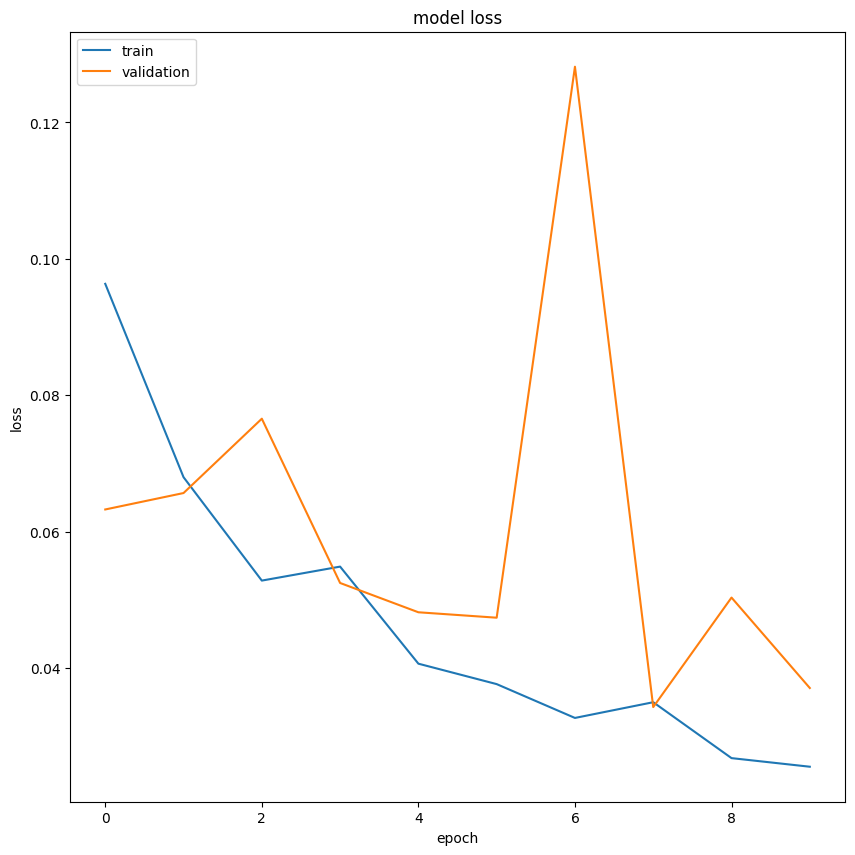

In [ ]:
#checking the performance on taining_data
plot_log_function(history)

In [ ]:
history_path = os.path.join(os.path.dirname(os.getcwd()),'content','experiments','resnet_mnist', 'history.log')
save_model_logs(history,history_path)

In [ ]:
path = os.path.join(os.path.dirname(os.getcwd()),'content','experiments','resnet_mnist', 'model.pkl')

model = load_model(path)

In [ ]:
# saving model architecture and hypermarameters
model_info = {
    "model_name": "Vision Transformer"
}
model_info["hyperparameters"] = hyperparameters
model_info["model_architecture"] = model.to_json()
model_info["model_architecture"]  = json.loads(model_info["model_architecture"] )

path = os.path.join(os.path.dirname(os.getcwd()),'content','experiments','resnet_mnist', 'mode_architecture.json')
dump_json(model_info, path )
print(model_info)

{'model_name': 'Vision Transformer', 'hyperparameters': {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 12, 'optimizer': 'adam', 'early_stopping_patience': 3}, 'model_architecture': {'class_name': 'Functional', 'config': {'name': 'ResNet34', 'trainable': True, 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 32, 32, 1], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'name': 'input_1', 'inbound_nodes': []}, {'class_name': 'ZeroPadding2D', 'config': {'name': 'zero_padding2d', 'trainable': True, 'dtype': 'float32', 'padding': [[3, 3], [3, 3]], 'data_format': 'channels_last'}, 'name': 'zero_padding2d', 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [7, 7], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kerne

In [ ]:
transformed_test_images= get_transformed_test_images(test_images)

In [ ]:
#saving model performance metrics
model_performance_metrics = {
    "model_name": "resnet34"
}
model_performance_metrics["train_images_performance_metrics"] = get_model_performance_metrics(model,train_images, train_labels)
model_performance_metrics["validation_images_performance_metrics"] = get_model_performance_metrics(model,val_images, val_labels)
model_performance_metrics["test_images_performance_metrics"] = get_model_performance_metrics(model, test_images, test_labels)
model_performance_metrics["transformed_test_images_performance_metrics"] = get_model_performance_metrics(model, transformed_test_images, test_labels)


path = os.path.join(os.path.dirname(os.getcwd()),'content','experiments','resnet_mnist', 'mode_performance_metrics.json')
dump_json(model_performance_metrics, path)
print(model_performance_metrics)

313/313 [==============================] - 3s 9ms/step
{'model_name': 'resnet34', 'train_images_performance_metrics': {'accuracy': 0.9965333342552185, 'precision': 0.9965439212261193, 'recall': 0.9965270582687659, 'f1_score': 0.9965333963619276}, 'validation_images_performance_metrics': {'accuracy': 0.9909999966621399, 'precision': 0.9908830945686041, 'recall': 0.9910789607006839, 'f1_score': 0.9909661272017523}, 'test_images_performance_metrics': {'accuracy': 0.9939000010490417, 'precision': 0.9938428803221433, 'recall': 0.9938193217725105, 'f1_score': 0.9938222745124519}, 'transformed_test_images_performance_metrics': {'accuracy': 0.6741999983787537, 'precision': 0.7977476779997776, 'recall': 0.6701383221835769, 'f1_score': 0.7024887731842709}}


Download your files

In [ ]:
# Create a zip file
!zip -r /content/experiments.zip /content/experiments
# Then downlod that zip file:
from google.colab import files
files.download("/content/experiments.zip")

updating: content/experiments/ (stored 0%)
updating: content/experiments/resnet_mnist/ (stored 0%)
updating: content/experiments/resnet_mnist/mode_architecture.json (deflated 97%)
updating: content/experiments/resnet_mnist/mode_performance_metrics.json (deflated 65%)
updating: content/experiments/resnet_mnist/model.pkl (deflated 8%)
updating: content/experiments/resnet_mnist/.ipynb_checkpoints/ (stored 0%)
updating: content/experiments/.ipynb_checkpoints/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>